#Week 4: Rolling dice to find motifs

## 1.1 Randomized Motif Search

1.  **Randomized Approach:** It is a Monte Carlo algorithm, which uses randomness to find approximate solutions quickly, rather than guaranteeing an exact one.
2.  **Initial Step:** The algorithm begins by selecting a random k-mer from each DNA string to form an initial collection of motifs.
3.  **Profile Creation:** From this current set of motifs, a profile matrix is constructed (often with pseudocounts to avoid zero probabilities).
4.  **Finding New Motifs:** This profile is then used to identify the single most probable k-mer in each of the original DNA strings.
5.  **Iterative Refinement:** The collection of these new "profile-most probable" k-mers becomes the input for the next iteration, starting the cycle of creating a profile and finding new motifs again.
6.  **Scoring and Comparison:** In each iteration, the score of the newly generated motifs is calculated and compared to the best score found so far.
7.  **Termination Condition:** The process continues as long as the score of the motifs keeps improving. It stops and returns the best-scoring motifs when an iteration fails to produce a better score.
8.  **Power in Repetition:** Because a single run can result in a poor outcome, the algorithm's strength comes from being executed many times (e.g., 1,000 or more), with the best result from all runs being selected.
9.  **Convergence:** Even with a poor random start, the iterative process can converge on the correct, highly conserved motif because each step tends to refine the profile towards the true signal.
10. **Practical Advantage:** Its speed makes it highly effective for finding longer motifs where other, more exhaustive algorithms (like MedianString) would be too slow to be practical.

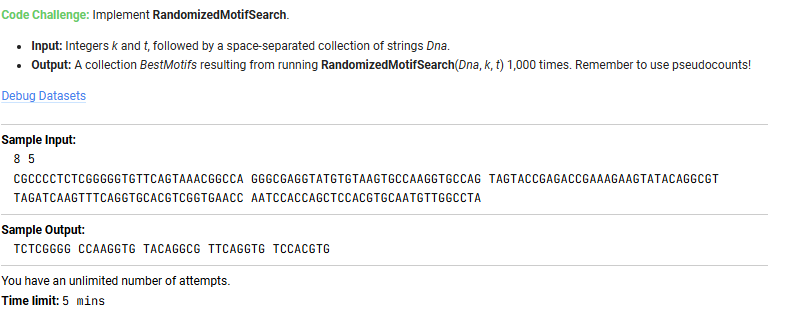

### The algorithm that we will use
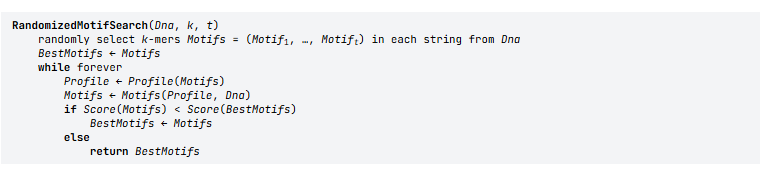

In [ ]:
import random
from collections import Counter

# --- YOUR HELPER FUNCTIONS (with one fix) ---

def CountWithPseudocounts(Motifs):
    k = len(Motifs[0])
    count = {symbol: [1] * k for symbol in "ACGT"}
    for motif in Motifs:
        for j, symbol in enumerate(motif):
            if symbol in count:
                count[symbol][j] += 1
    return count

def ProfileWithPseudocounts(Motifs):
    t = len(Motifs)
    k = len(Motifs[0])
    count = CountWithPseudocounts(Motifs)
    denominator = t + 4
    profile = {s: [c / denominator for c in count[s]] for s in "ACGT"}
    return profile

# --- THIS IS THE FIXED SCORE FUNCTION ---
# It now uses the profile with pseudocounts to be consistent.
def score_motifs_with_pseudocounts(motifs):
    if not motifs:
        return 0

    k = len(motifs[0])
    t = len(motifs)
    total_score = 0

    # Generate the consensus from the same profile logic used elsewhere
    profile = ProfileWithPseudocounts(motifs)
    consensus = ""
    for j in range(k):
        max_prob = 0
        best_nuc = ''
        for nuc in "ACGT":
            if profile[nuc][j] > max_prob:
                max_prob = profile[nuc][j]
                best_nuc = nuc
        consensus += best_nuc

    # Calculate score by counting mismatches to this consensus
    for motif in motifs:
        for j in range(k):
            if motif[j] != consensus[j]:
                total_score += 1

    return total_score

def Probability_ofPattern(Pattern, Profile):
    product = 1.0
    for i, nucleotide in enumerate(Pattern):
        product *= Profile[nucleotide][i]
    return product

def Profile_most_probable_kmer(Text, k, Profile):
    max_prob = -1
    most_probable_kmer = Text[0:k]
    for i in range(len(Text) - k + 1):
        pattern = Text[i:i+k]
        prob = Probability_ofPattern(pattern, Profile)
        if prob > max_prob:
            max_prob = prob
            most_probable_kmer = pattern
    return most_probable_kmer

# --- The Corrected Main Loop ---

def RandomizedMotifSearch(Dna, k, t, num_runs=1000):
    BestMotifs_Overall = []
    BestScore_Overall = float('inf')

    for run_num in range(num_runs):
        # 1. Randomly select initial motifs
        Motifs = []
        for dna in Dna:
            start = random.randint(0, len(dna) - k)
            Motifs.append(dna[start:start+k])

        BestMotifs_In_Run = Motifs

        # 2. Iteratively improve motifs
        while True:
            profile = ProfileWithPseudocounts(BestMotifs_In_Run)

            Current_Motifs = [Profile_most_probable_kmer(dna_string, k, profile) for dna_string in Dna]

            # Use the CONSISTENT scoring function
            if score_motifs_with_pseudocounts(Current_Motifs) < score_motifs_with_pseudocounts(BestMotifs_In_Run):
                BestMotifs_In_Run = Current_Motifs
            else:
                break

        # 3. Compare result of this run with the overall best
        current_run_score = score_motifs_with_pseudocounts(BestMotifs_In_Run)
        if current_run_score < BestScore_Overall:
            BestScore_Overall = current_run_score
            BestMotifs_Overall = BestMotifs_In_Run

    return BestMotifs_Overall

# --- Running the code with your dataset ---
dataset = """15 20
TTCATTCAGTTGGAAAGTGCGAGGTCAGTACACCCAGATCATTGGGCAGTACCACGTTACACGCCCGCGCAGGGTACAAAGCAAGAAATACCTGTGTGGCGCGCATAACGGTTGAGTCAAAAAGGCCGATACCGACGATATCGTGAGACTGTGATGCTCAACAAATACCGTGGTTCCGAGCCTGTTCATTCAGTTGGAA AGTGCGAGGTCAGTACACCCAGATCATTGGGCAGTACCACGTTACACGCCCGCGCAGGGTACAAAGCAAGAAATACCTGTGTGGCGCGCATAACGGTTGAGTCAAAAAGGCCGATACCGACGATATCGTGAGACTCGTGGGAATGTTCGTGTGATGCTCAACAAATACCGTGGTTCCGAGCCTGTTCATTCAGTTGGAA CCTGAGGCAAGACTCCAGGGTTCAGACCGACTTGATTACGCTCGACTCATCTTGGCGCTGGTGTGAATCGTAATGGGTATAAATTCCGTAATGGCGCAGCGCATGCTGCAGTGCGAATAGTCGTTAATCCGTTCGTATATTATCTGGTCTGTTAGGCGGACACGCCCTATGTCTGTCTGAACAGAGCTGCAACATACCA GGCAAAGTCGTTTAACCTGTCCCTAAAGCCCATCATGAGTAACCTTGACCGTAAATCTATGACATTTACACATGTTCGATGCATGTTATGGGCAACGAGTGCGATCACAACGTTAGTTTGTTCGTGCCCACTCTGCTACTTTAATTCAAGCACGCTTATCCTTAATGTTACAACTCAATCCCATTTAGGTTGCTCAGCA ATTGAACTGCTAATGACCTTCGGCCAGCCACAACTCATGAAGGGTAATTTCACTAACGAGAGTAGTAATCGGCGAGCCTTGGCGTGGACTACCAATCTCAAGTTCGGTCGCTTTTAAAATGTTCGAAGAGCGTGGCGCCGAGGCCTATAAGATGAGTTTCCCCCCAGAGGGTTCGGGCTACGGGCATGCTATCGTATTA CTTTAGAGCAGGTTTCTTACATGTATTTTCTTCAATAGAAGCTATGTACCCGTGACATCCTCTTTGTTTGTCGTTAAAATGCCAGTGTCTCATTGGTTGCAGGGCTGCGGCCAGGCGCATCCGCGTAGTGATGTTATGGCGTAGGAACGTGTGACACATATGGTACTCGACCGACCTAAGCAAACGAACCGAAATGCCC AGCGAGTTATCTCCCGGTATTTTGTGTTCAAAGTTGTCTAAGATGCAACTAAGTCTTAATTAACCATCATCTGTAAGGTAAGTTAAAATGTTCCGGCATTCCCAAGGCCGGATCACTCATAGATTCTTTCCAAGAGCAGTGGCATTCAACTGCTCGCGGTCAACCATATCGAATATCTGTTCTCACGTTAAATTGTCGT ACTAACGGCTGGACGCTGTAATAAGCTATATCTCACTCCCACGCCGACTTTCTTTCCCTGAGCAGCACAGGTGACGGTTATTAGAGCTGTCTTGAGATTTGAGTAAGTGCGAGTTGTACTTGGGACGCCGTTAAAATGTATCTAGAGAGATCGCGAAGGTAGACCGCTTGTTAATGGCGGCTTAGCGCATCGCGTACGG CGAATACAAAACCATATCGTCAGCGAATGTTCGCATCGGTCCGAGTTGACTTCTTCTACGCTTACGTGGAACGTTTTCATGTTCGTCAAGAAGCCTAGTGGGATGTAACTAGATCCATGGTCAGATCAAGGGCACCTAGTGGTAAAGCGGCGCTGATGCCATTCAATATATCTTCGAAAGGAGTCAACCTGTTAGGACG GGCACTATTTACTGTATCTCTCGGCGTGCGAATGTTCGTCGCTCGCTAGCAATATCTGTGGCGTTCGAGAGGGACGTACTGGGATATCTGTTAGGTCGATCTTAGCTCCCACGCCCCCGCAGGCTTCAAACGTCGGTTGGCTGGAATTGCGGCATAGGGAGAAGGAGCGCCTATAGAACGAGGTACCGCCGATGATGAT GTGTAGCTACATGGTAGTAACGCATCATCCTGATCAGTATAGCACAGATCCACCAGTGGAGAACTCTCCCGCGTTAGCACGCTGGTGTCATCACGAGACCCCCAAAATGTTCGTCCGAAGCGCGATCTTAACATAAGGGACTACTTTCCACAGATTGCAATTAATATTATGGCGGTATTATGTGACCTGAAAGAACACA CCAGCGAGTGTAGGTGGAAAGACGTTTGCAGATCGGGAACGCGCTGCAGTACGCCCATTCCTCGCCGTGCGTCTGATAAACGCAGTAGCTATGATGTCGTTAAATGGATGGGACACCTGCCCGGAGACGCGGCCTTGACCTGCGCGTCCTTCTTGAGCCGCGCCAGTACTGCGCGCCGAAATGTTCGTCGATAAACCGC GCTGACTCTTCGGGAAATACGTTATCATGGGGGTGCTCACAATCGTCCACGCCCAACGGCCCGCGGCCGGGTAATCTTGTTACAGCTCTCGTCCCACGGCTCCGTTAAAATGTTATCATTCACTGCGCTTCGAATTGTGCTGTAACTTAGTCTTTCTTCACTTTCACTGAAGAGAACTTAGCACTTCCAGTCCGATGCT GTTCAAACATTTCAACATCCCCATTCCTTACCCACTATTGAAACCTGTCTCTAAGCGAACAGGTCCAGGGAGGCATAGTGTCGCCCCTAGTAGTTGCTAATTGCGTTCGGATGTTCGTACTGATAAAGGGGTCATCTGGCGCTTCAGGTGGGTGGGGCACGAACAGATAGTTCGTCCCATTGTCGCAATCATCTCTTCA GAGCTTTTGCCGATCTTTGTTTTAAAAGGCCCGTACCCTGCGTTAAGCGGTTCGTCCCATTTAAAGCGGGAAGGGTTACTTACCGTATGACGATTATACACTGTGACACATGGCCCCTGCAATCACACCTGTTTGTAACGAGTAGATGACTAGCTAGAGGAGCAGATATGGTTCTTTATTAGAACGGCGGTCTCCGTCT GTCGCCTTTAGCTGGGAGTGTATTCCGGGGGCCGTTAAGTACTTGGCTCGTTACGTCGTGGTGCACGTGACTTATCCACTTCCTACCGCCCTCGTGCGATGTTACGTTAAAATACCCGTAGTTATACAACCCCTACATAATTGCCCAGTTACCCATTCGGGGACACCACACTAATAGACCGACTGGTGGTTAGACCTGA GGAGTACTATAACGTTCTGCCGTTGTCAGCTGGGCAGACTTGTATGCTGACTAATGCTGATGGTAACAAACGTGCCTTGTACGCTATTGCGTATTCTACCGTACACTTTAATCTAAGATATCATTTGTTGTAAGGAAGTGGGTCGATTGCAGGTGCTAGTACCATGCCGCTCGCGTTAAACCATTCGTAACCAATAAGA TACGACTAGGTAAGTATGATGCTTCAAAGATAACTCGGGCCGCACGGGAGTGACGCTACAATTGGGCCAGCCCGTTGGCCGTCCCTTCTACCCGAATTTGCGCCTGTTGAGAGGCCCACTACCTGCGTTAGCCTGTTCGTGGGAAGTGAGTGAGAATAGTTGATAGATCTAGATTTAGTGGTTAGTGAAAGACTTCCGT AAAAACCGCGTGAGTCCCGGAGGAGGCCTCACACCCTCCATGGGTATCTAAATATTGCCATGGTCACTGCATGCATCAGCGGCGTAGCTGGGCCAAATGGCGACGGGCCTCCCCACGCCATGCGCTTAACCTCTAGCCCCGGGTCCTATTAATAGACGTAAAATGTTCGTGTTTAGGTAGACAACATTAGAAACGGGTC CACTTCGGAAGAGCAATTAGAGTGTCAACCCGCTACATCGGACTTTAAAAATATAGTCGAATATACAAAGAATTCATCATGGAGTGTACTAATGGTCCGCCTCCTCCTGTTTCACTATTTCCCAGGTTAAATACGCAAATGCTTCTATCTGCACGCGTCAGATCTTTGAGAAATCGTTAAAAAAGTCGTCTTTGTGATC
"""
ktdna = dataset.strip().split()
k = int(ktdna[0])
t = int(ktdna[1])
Dna = ktdna[2:]

# Run the final algorithm
best_motifs = RandomizedMotifSearch(Dna, k, t, num_runs=1000)

# Print the result
for motif in best_motifs:
    print(motif)

AGTTGGAAAGTGCGA
CGTGGGAATGTTCGT
CGTTAATCCGTTCGT
CGTTAGTTTGTTCGT
TTTTAAAATGTTCGA
CGTTAAAATGCCAGT
AGTTAAAATGTTCCG
CGTTAAAATGTATCT
CGTTTTCATGTTCGT
CGTGCGAATGTTCGT
CCCCAAAATGTTCGT
CGCCGAAATGTTCGT
CGTTAAAATGTTATC
CGTTCGGATGTTCGT
CGTTAAGCGGTTCGT
CGTTAAAATACCCGT
CGTTAAACCATTCGT
CGTTAGCCTGTTCGT
ACGTAAAATGTTCGT
CGTTAAAAAAGTCGT


In [ ]:
" ".join(map(str, best_motifs))

'AGTCAAAAAGGCCGA CGTGGGAATGTTCGT CGTTAATCCGTTCGT CGTTAGTTTGTTCGT TTTTAAAATGTTCGA CGTTAAAATGCCAGT AGTTAAAATGTTCCG CGTTAAAATGTATCT CGTTTTCATGTTCGT CGTGCGAATGTTCGT CCCCAAAATGTTCGT CGCCGAAATGTTCGT CGTTAAAATGTTATC CGTTCGGATGTTCGT CGTTAAGCGGTTCGT CGTTAAAATACCCGT CGTTAAACCATTCGT CGTTAGCCTGTTCGT ACGTAAAATGTTCGT CGTTAAAAAAGTCGT'

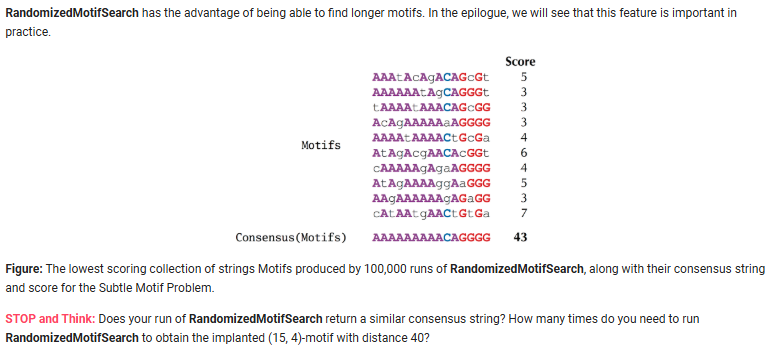

In [ ]:
k = 15
t =4

In [ ]:
RandomizedMotifSearch(Dna, k, t, num_runs=100000)

['AGTTGGAAAGTGCGA',
 'CGTGGGAATGTTCGT',
 'CGTTAATCCGTTCGT',
 'CGTTAGTTTGTTCGT',
 'TTTTAAAATGTTCGA',
 'CGTTAAAATGCCAGT',
 'AGTTAAAATGTTCCG',
 'CGTTAAAATGTATCT',
 'CGTTTTCATGTTCGT',
 'CGTGCGAATGTTCGT',
 'CCCCAAAATGTTCGT',
 'CGCCGAAATGTTCGT',
 'CGTTAAAATGTTATC',
 'CGTTCGGATGTTCGT',
 'CGTTAAGCGGTTCGT',
 'CGTTAAAATACCCGT',
 'CGTTAAACCATTCGT',
 'CGTTAGCCTGTTCGT',
 'ACGTAAAATGTTCGT',
 'CGTTAAAAAAGTCGT']

#1.2 How Can a Randomized Algorithm Perform So Well?


1.  **Random Start, Varied Outcomes:** The `RandomizedMotifSearch` algorithm begins by selecting a random collection of k-mers from the DNA sequences. The initial quality of this guess can range from useless (if it creates a uniform profile where all nucleotides are equally likely) to perfect (if it luckily selects all the true implanted motifs).

2.  **The Key Insight: DNA is Not Random:** The algorithm's effectiveness relies on the fact that the target DNA sequences are not random. They have a built-in statistical signal—the repeated presence of the implanted motif—which a randomized process can eventually detect.

3.  **The "Lucky Capture" Phenomenon:** Even with a random start, there's a significant probability of accidentally selecting at least one of the true implanted motifs. This "lucky capture" is the critical event that prevents the initial profile from being completely uniform and useless.

4.  **Creating a Statistical Bias:** A captured motif immediately skews the profile matrix. For example, if a captured motif has a 'C' in the second position, the probability for 'C' in the second column of the profile will rise above 0.25, creating a bias or a "clue" that points toward the true motif's structure.

5.  **Initiating a "Virtuous Cycle" (Addition):** This initial, small bias is crucial for the algorithm's iterative nature. In the next step, the biased profile is used to scan the DNA, making it more likely to select other k-mers that also match this weak pattern. This, in turn, strengthens the profile's bias, creating a feedback loop that can guide the search toward the correct answer.

6.  **The Power of Repetition (Addition):** The probability of finding the optimal motif in a single run is often low. The true power of randomized algorithms comes from repetition. By running the search thousands of times with different random starting points, we dramatically increase the chance that at least one of those runs will begin with a "lucky capture" strong enough to converge on the correct solution.

7.  **A Single Capture is Often Not Enough:** The text cautions that capturing just one implanted motif might not create a strong enough statistical signal. If the rest of the randomly selected k-mers are very different, their "noise" can overwhelm the "signal" from the single correct motif, causing the algorithm to fail on that particular run.

8.  **Probability is Key:** The success of the algorithm is a numbers game. While the probability of capturing *all* motifs at the start is negligible, the probability of capturing *at least one* is significant. The strategy is to leverage this probability over many independent runs to overcome the low chance of success in any single attempt.

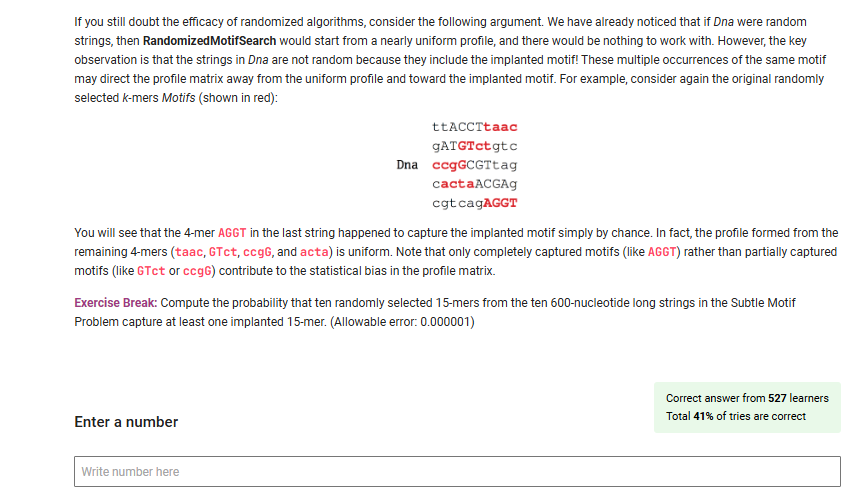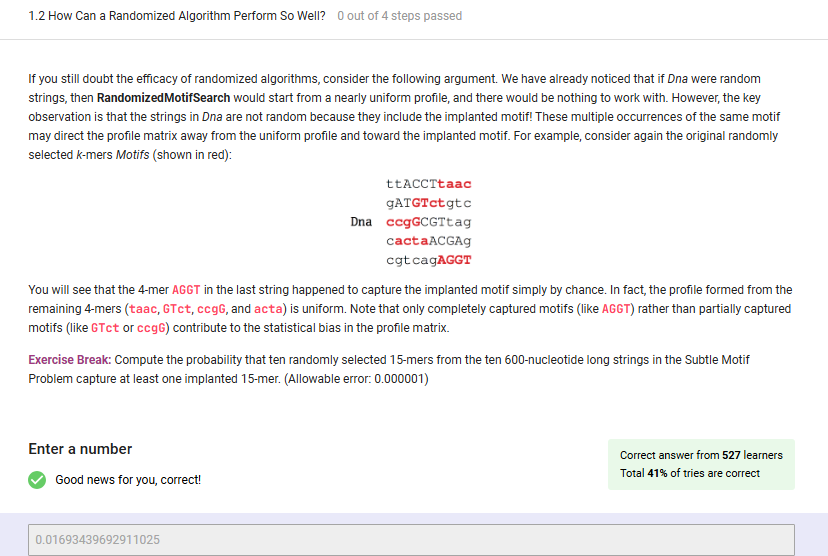

In [19]:
# The following is thanks to learner Robert Kwapich.

#   1. First you compute p1 - probability of not capturing the implanted k-mer (15-mer) in one string.
k = 15
p1 = (600-k ) / (600-k+1)

# 2. Then you notice for the entire problem we have to deal with ten similar cases, i.e. you have to multiply p1 * p2... *p10, where p1 = p2 = ... = p10. So you just compute p1 to the 10th power:

pC = pow(p1,10)

# 3. Then you just compute the 'opposite' probability, i.e. the probability that from ten 600-length nucleotide string, we capture at least one implanted 15-mer!

pAnswer = 1 - pC
pAnswer

0.01693439692911025

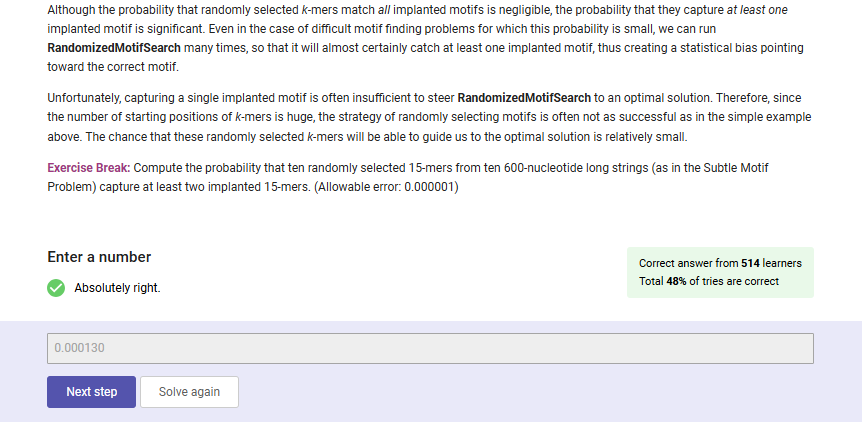

In [20]:
import math

# --- Setup: Define the parameters from the Subtle Motif Problem ---

# Length of the k-mer (the motif)
k = 15

# Length of each of the DNA strings
string_length = 600

# Number of DNA strings we are sampling from (and number of trials)
num_strings = 10

# --- Core Probability Calculations ---

# 1. Calculate the total number of possible k-mers in a single string.
# A 15-mer can start at position 1, 2, ..., up to (600 - 15 + 1).
total_positions = string_length - k + 1

# 2. Calculate the probability of a "hit" (capturing the motif) in a single trial.
# There is 1 implanted motif out of all possible positions.
p_hit = 1 / total_positions

# 3. Calculate the probability of a "miss" in a single trial.
# This is the complement of a hit.
p_miss = 1 - p_hit

# --- Print the basic probabilities for clarity ---
print("--- Basic Probabilities for a Single String ---")
print(f"Total possible {k}-mer starting positions: {total_positions}")
print(f"Probability of a HIT (p): {p_hit:.8f}")
print(f"Probability of a MISS (q): {p_miss:.8f}")
print("-" * 50)


# --- EXERCISE 1: Probability of capturing AT LEAST ONE motif ---

# We use the complement rule: P(at least one) = 1 - P(exactly zero)
# P(exactly zero) means we miss on all 10 independent trials.
p_zero_hits = p_miss ** num_strings

# The final probability is 1 minus the probability of getting zero hits.
p_at_least_one = 1 - p_zero_hits

print("EXERCISE 1: Probability of capturing AT LEAST ONE motif\n")
print(f"P(zero hits) = q^n = {p_zero_hits:.8f}")
print(f"P(at least one) = 1 - P(zero hits) = {p_at_least_one:.8f}")
print(f"The number to enter is: {p_at_least_one:.6f}")
print("-" * 50)


# --- EXERCISE 2: Probability of capturing AT LEAST TWO motifs ---

# We use the complement rule again: P(at least two) = 1 - [P(zero hits) + P(one hit)]

# We already have P(zero hits). Now we calculate P(one hit).
# This uses the binomial probability formula: C(n, k) * p^k * q^(n-k)
# Here, n=10 (num_strings) and k=1 (we want exactly one hit).

# C(10, 1) is the number of ways to choose which of the 10 strings gets the hit.
combinations_for_one_hit = math.comb(num_strings, 1)  # This will be 10

p_one_hit = combinations_for_one_hit * (p_hit ** 1) * (p_miss ** (num_strings - 1))

# The final probability is 1 minus the sum of the probabilities of the unwanted outcomes.
p_at_least_two = 1 - (p_zero_hits + p_one_hit)

print("EXERCISE 2: Probability of capturing AT LEAST TWO motifs\n")
print(f"P(exactly one hit) = C(10, 1) * p^1 * q^9 = {p_one_hit:.8f}")
print(f"P(at least two) = 1 - (P(zero) + P(one)) = {p_at_least_two:.8f}")
print(f"The number to enter is: {p_at_least_two:.6f}")
print("-" * 50)

# --- Alternative calculation for Exercise 2 (Keith Bloom's method) ---
# This confirms the result using the logic from the spoiler text.
p_at_least_two_alternative = p_at_least_one - p_one_hit
print("Alternative calculation for Exercise 2 (Keith Bloom's method)\n")
print(f"P(at least two) = P(at least one) - P(exactly one)")
print(f"Result: {p_at_least_one:.8f} - {p_one_hit:.8f} = {p_at_least_two_alternative:.8f}")

--- Basic Probabilities for a Single String ---
Total possible 15-mer starting positions: 586
Probability of a HIT (p): 0.00170648
Probability of a MISS (q): 0.99829352
--------------------------------------------------
EXERCISE 1: Probability of capturing AT LEAST ONE motif

P(zero hits) = q^n = 0.98306560
P(at least one) = 1 - P(zero hits) = 0.01693440
The number to enter is: 0.016934
--------------------------------------------------
EXERCISE 2: Probability of capturing AT LEAST TWO motifs

P(exactly one hit) = C(10, 1) * p^1 * q^9 = 0.01680454
P(at least two) = 1 - (P(zero) + P(one)) = 0.00012986
The number to enter is: 0.000130
--------------------------------------------------
Alternative calculation for Exercise 2 (Keith Bloom's method)

P(at least two) = P(at least one) - P(exactly one)
Result: 0.01693440 - 0.01680454 = 0.00012986


# 1.3 Gibbs Sampling


1.  **Core Philosophy: A More Cautious Approach:** Unlike `RandomizedMotifSearch` which replaces all motifs at once, Gibbs Sampling is more conservative. It modifies only a single, randomly chosen k-mer at each iteration, reducing the risk of accidentally discarding a correctly identified motif.

2.  **The "Leave-One-Out" Strategy:** The central loop of the algorithm is based on a "leave-one-out" method. At each step, it randomly selects one of the `t` DNA sequences and temporarily ignores its current motif.

3.  **Profile from the Majority:** It then constructs a profile matrix using the motifs from the remaining `t-1` sequences. This profile represents the current consensus pattern based on the vast majority of the data.

4.  **Probabilistic Selection, Not Deterministic:** This is the key difference from other greedy algorithms. Instead of just picking the single *most* probable k-mer from the excluded sequence, Gibbs Sampling calculates a probability for *every* possible k-mer in that sequence based on the `t-1` profile.

5.  **The "Biased Die Roll":** The algorithm then uses these probabilities to perform a weighted random choice, like rolling a biased multi-sided die. A k-mer that fits the profile well has a high probability of being chosen, but it is not guaranteed.

6.  **Updating the Motifs:** Once a new k-mer is randomly selected (via the "die roll"), it replaces the old k-mer for that sequence. The collection of motifs is now updated, and the iterative process repeats.

7.  **Escaping Local Optima:** The randomness is a crucial feature. By allowing the algorithm to occasionally select a k-mer that is *not* the best fit (i.e., one that temporarily worsens the score), it can "jump" out of a suboptimal solution (a "local optimum") and explore other possibilities that may lead to the true best answer.

8.  **Pseudocounts are Still Essential:** Just like in other motif finders, if a nucleotide never appears in a column of the `t-1` motifs, the profile would have a zero. This would make it impossible to ever select a new k-mer containing that nucleotide. Pseudocounts (like Laplace's Rule) are used to avoid this, ensuring every k-mer has a non-zero chance of being selected.

9.  **Tracking the Best Solution:** Because the algorithm can move to a worse-scoring state, it continuously keeps a separate record of the `BestMotifs` found so far. The final output is this best-ever set, not the set from the final iteration.

10. **Repetition is Mandatory:** A single run of Gibbs Sampling is not reliable. Because its path is influenced by random choices, it can get stuck. The standard strategy is to run the algorithm hundreds or thousands of times with different random starting points to maximize the chance of finding the global optimum.

11. **Convergence as a Signal (Addition):** A successful run of GibbsSampler often shows signs of convergence. As the profile gets stronger and more accurate, the "biased die roll" will more consistently select the same high-scoring k-mers, indicating that the algorithm has locked onto a strong, repeating signal.

12. **Computational vs. Biological Optimum (Addition):** The text notes that on the Subtle Motif Problem, GibbsSampler can find a solution with a *better score* than the actual implanted motifs. This highlights a key concept: the scoring function is just a mathematical model, and the computationally "optimal" solution may not perfectly match the true biological pattern.

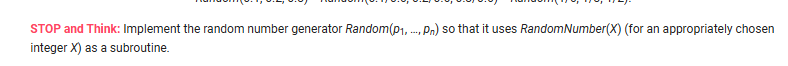

In [1]:
import random

def biased_random_generator(probabilities):
    """
    Implements Random(p1, ..., pn) using a standard uniform random number generator.

    Args:
        probabilities (list of float/int): A list of non-negative numbers (weights).
                                           They do not need to sum to 1.

    Returns:
        int: The 0-based index `i` chosen with a probability proportional to p_i.
    """
    # Calculate the total sum of the probabilities/weights.
    total_sum = sum(probabilities)

    # Handle the edge case where all probabilities are zero.
    # In this case, we can't make a weighted choice, so we return a uniform random choice.
    if total_sum == 0:
        return random.randint(0, len(probabilities) - 1)

    # This is our "dart throw" on the number line from 0 to total_sum.
    # This corresponds to the "RandomNumber(X)" part of the prompt.
    random_pick = random.uniform(0, total_sum)

    # Iterate through the probabilities to find which interval the pick falls into.
    current_sum = 0
    for i, prob in enumerate(probabilities):
        current_sum += prob
        if random_pick < current_sum:
            return i

    # This line should theoretically never be reached due to float precision,
    # but as a fallback, return the last index.
    return len(probabilities) - 1

# --- DEMONSTRATION using the text's example ---
print("--- Demonstration with Random(0.1, 0.2, 0.3) ---")
weights = [0.1, 0.2, 0.3]
# The theoretical probabilities are:
# p0 = 0.1 / 0.6 = 1/6 (~16.7%)
# p1 = 0.2 / 0.6 = 1/3 (~33.3%)
# p2 = 0.3 / 0.6 = 1/2 ( 50.0%)

# Let's run the simulation many times to see if the results match the theory.
num_trials = 100000
results = {0: 0, 1: 0, 2: 0}

for _ in range(num_trials):
    chosen_index = biased_random_generator(weights)
    results[chosen_index] += 1

print(f"Running {num_trials} trials...")
print(f"Index 0 was chosen {results[0]} times. (~{(results[0]/num_trials)*100:.2f}%)")
print(f"Index 1 was chosen {results[1]} times. (~{(results[1]/num_trials)*100:.2f}%)")
print(f"Index 2 was chosen {results[2]} times. (~{(results[2]/num_trials)*100:.2f}%)")

--- Demonstration with Random(0.1, 0.2, 0.3) ---
Running 100000 trials...
Index 0 was chosen 16396 times. (~16.40%)
Index 1 was chosen 33586 times. (~33.59%)
Index 2 was chosen 50018 times. (~50.02%)


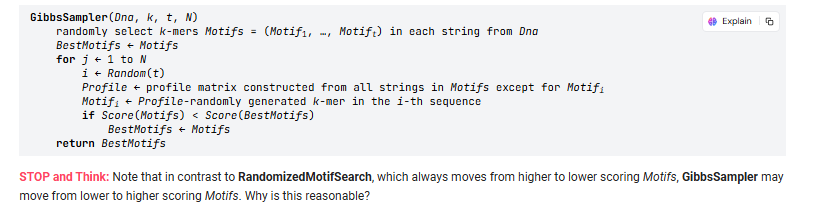

### Answer: This is the algorithm's single most important feature, and it is what allows it to escape local optima.

In [5]:
import random

# --- Helper Function from the previous step ---
def biased_random_generator(probabilities):
    """Simulates a biased die roll."""
    total_sum = sum(probabilities)
    if total_sum == 0:
        return random.randint(0, len(probabilities) - 1)

    random_pick = random.uniform(0, total_sum)
    current_sum = 0
    for i, prob in enumerate(probabilities):
        current_sum += prob
        if random_pick < current_sum:
            return i
    return len(probabilities) - 1

# --- Helper Functions for Motif Finding ---
def create_profile_with_pseudocounts(motifs):
    """Creates a profile matrix from a list of motifs with pseudocounts."""
    k = len(motifs[0])
    t = len(motifs)
    profile = {'A': [1] * k, 'C': [1] * k, 'G': [1] * k, 'T': [1] * k}

    for i in range(k):
        for j in range(t):
            nucleotide = motifs[j][i]
            profile[nucleotide][i] += 1

    # Normalize to probabilities
    for nucleotide in profile:
        for i in range(k):
            profile[nucleotide][i] /= (t + 4) # t motifs + 4 pseudocounts

    return profile

def score(motifs):
    """Calculates the score of a collection of motifs."""
    k = len(motifs[0])
    t = len(motifs)
    score = 0

    for i in range(k):
        counts = {'A': 0, 'C': 0, 'G': 0, 'T': 0}
        for j in range(t):
            nucleotide = motifs[j][i]
            counts[nucleotide] += 1

        max_count = max(counts.values())
        score += (t - max_count)

    return score

def kmer_probability(kmer, profile):
    """Calculates the probability of a k-mer given a profile."""
    prob = 1.0
    for i, nucleotide in enumerate(kmer):
        prob *= profile[nucleotide][i]
    return prob

def profile_randomly_generated_kmer(text, k, profile):
    """Finds a profile-randomly generated k-mer in a string."""
    n = len(text)
    probabilities = []

    for i in range(n - k + 1):
        kmer = text[i:i+k]
        probabilities.append(kmer_probability(kmer, profile))

    # Use the biased random generator to pick an index
    chosen_index = biased_random_generator(probabilities)

    return text[chosen_index : chosen_index + k]


# --- Main GibbsSampler Algorithm ---
def GibbsSampler(Dna, k, t, N):
    """
    Performs the Gibbs Sampler algorithm for motif finding.

    Args:
        Dna (list of str): The collection of DNA strings.
        k (int): The length of the k-mer.
        t (int): The number of strings in Dna.
        N (int): The number of iterations to run.

    Returns:
        list of str: The best motifs found during the run.
    """
    # 1. Start with randomly selected k-mers from each string
    motifs = []
    for text in Dna:
        start = random.randint(0, len(text) - k)
        motifs.append(text[start : start + k])

    # 2. Initialize BestMotifs and BestScore
    best_motifs = list(motifs)
    best_score = score(best_motifs)

    # 3. Main iterative loop
    for j in range(N):
        # Randomly select a string index to remove
        i = random.randint(0, t - 1)

        # Create a collection of motifs without the i-th motif
        motifs_subset = motifs[:i] + motifs[i+1:]

        # Form a profile from this subset
        profile = create_profile_with_pseudocounts(motifs_subset)

        # Choose a new k-mer from the removed string Dna[i] based on the profile
        motifs[i] = profile_randomly_generated_kmer(Dna[i], k, profile)

        # Compare scores and update BestMotifs if necessary
        current_score = score(motifs)
        if current_score < best_score:
            best_score = current_score
            best_motifs = list(motifs)

    return best_motifs

# --- Example Usage with Multiple Starts (as suggested by the full problem) ---
if __name__ == '__main__':
    # Sample Input from the problem description
    k = 8
    t = 5
    N = 100
    Dna =['CGCCCCTCTCGGGGGTGTTCAGTAACCGGCCA',
 'GGGCGAGGTATGTGTAAGTGCCAAGGTGCCAG',
 'TAGTACCGAGACCGAAAGAAGTATACAGGCGT',
 'TAGATCAAGTTTCAGGTGCACGTCGGTGAACC',
 'AATCCACCAGCTCCACGTGCAATGTTGGCCTA']

    num_starts = 100

    # Run GibbsSampler multiple times and keep the best result
    overall_best_motifs = []
    overall_best_score = float('inf')

    for _ in range(num_starts):
        current_motifs = GibbsSampler(Dna, k, t, N)
        current_score = score(current_motifs)

        if current_score < overall_best_score:
            overall_best_score = current_score
            overall_best_motifs = current_motifs

    print("Best score found:", overall_best_score)
    print("Best motifs found:")
    for motif in overall_best_motifs:
        print(motif)

Best score found: 9
Best motifs found:
TCTCGGGG
CCAAGGTG
TACAGGCG
TTCAGGTG
TCCACGTG


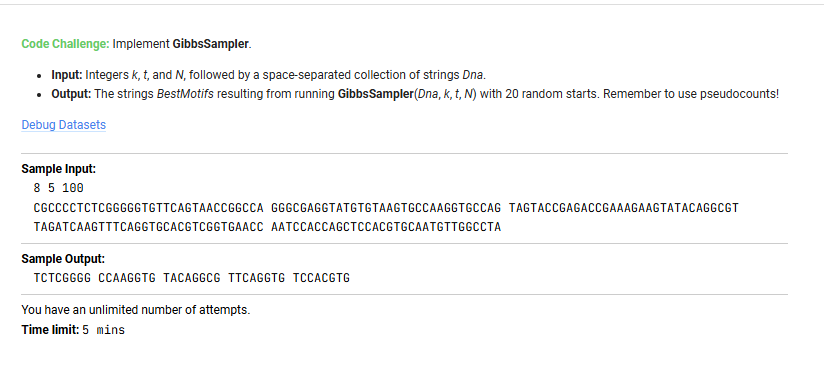

In [10]:
#@title Dataset given in the challenge
k=15
t=20
N=2000
Text = "AAATATCGCATTCACACGCAGCGAAAAGCTACTACCCAAAGCGGCAAGACCCAAGGAATCGACGCTAGTGTTTATCGACGTCGGGGGGGAGGGGTAGCCCGGGAAAGTGACTGGAGAAGTAGTTTTGGCGTTTGTGACATGCAAATATACCCAAGTTTAGGCTCGGGGAAGCCGTACCAGGATTTTAGCCGACTTAAATCTAACAGCTACCGGCCTACAAATCCGCGTGCTCTCGAGTATTATTCTCAATGTCTAATGAGCGCAAGTCACAATGTGCGTAAGGTTATGACATCGGTCATTTCAAATATCGCATTCAC ACGCAGCGAAAAGCTACTACCCAAAGCGGCAAGACCCAAGGAATCGACGCTAGTGTTTATCGACGTCGGGGGGGAGGGGTAGCCCGGGAAAGTGACTGGAGAAGTAGGCCGCTCCATGGTAGTTTTGGCGTTTGTGACATGCAAATATACCCAAGTTTAGGCTCGGGGAAGCCGTACCAGGATTTTAGCCGACTTAAATCTAACAGCTACCGGCCTACAAATCCGCGTGCTCTCGAGTATTATTCTCAATGTCTAATGAGCGCAAGTCACAATGTGCGTAAGGTTATGACATCGGTCATTTCAAATATCGCATTCAC AGTTCCCCCACTGAAATTTACTATCAGAGACATACTGAGGAGCCAGTTGCTTTCGGCACTTGGTTTCGGAGCTCCATACCCTGCCTTGATGTTCCGTCCCTCTCCGCACCATAAGTGGGAACAGTAATTTGTTATATAAGTAATGAGTAGCGGTGAGATCTTAAGTGGCATAAACCCGAAGTCGTGACTCGCCTAGCATCCGGCAAGTCGTCTCCAGCGGAGCATTACTGCGCAGTTACGGTACTAAATCGCGCTCGCCAGTATATTTTAGACCGTCGAGCAAGGTAATAAAGCCCTACCATCCGAGGTCAAGATCT CGACCACGTGGCGCGCAAGAATGTTATGCAGTCGTAGCAATTTATAGAACCAGTTCAGAAATGCATTTATTCATTTACAAGACTATTGGCTCCTATATTCACTCATTGGGCCCGTACATGGTAGTTCGCTTCGGAACCTGAGACAGTCTGCGTCGCCGGAAGCGACCAAATGGGCTCACAGCATGTTCAGAGGCCGCAACGAGAGAGATAATAAAGCTAGAAAATCCGACACCCCCGTACCGCCGTCGTATTAGATTTTCTGTACTCGGCTGAGGGACCGATTTCCGAGGCGTGTAGCCACCGGGTGTCTCGTAAAT TCCTCAGTTAATGTGTCCGTTATGTTGTCAAATTTGTTAAAGTTCCTGCCATCCAAAGTGAGAGTCTAGAGCGCGTGACCATGGTAGGTTGGTCGGGAGAGGTAGTAGGAACGACTGCTAGGTTCAGGAGCTTATAAGGCGCCGAGGAGGGATAGCTTTATCAGGCGAGAGGTGCAACGTTCGTATCTCCAATAAACCTATAGGCCCCAGACTCCCTAACTTGCAGTCTTAACTAATGTAACGCATTGGTTCTATTTGTCGAGCCAGATCGATTCCGTCTCGTGCCGGTGACGTGTAAGCAATTCATTTCGATCCGT TGACCTTAACTACTATGCTTGGTGATGTTTAACCTTCAACCTGCCTCGGCCTAGATGACTGGCGCTAAGAACTTTTAATTTAAGGGTCTTGGTACTATCGCTTTGAGAGGATATCCCTAGTGAGCCCTACCATGGACTATAATCACCTACTACGCACTAGCGTCGTCTGTGCTAGATTCCATCACGTTCGCCTTCTTGCGCGGGGGGCGGGAATCGCATTGGTTGGGTATATGCGTCTGCCTCTTGAAGGATTGATGGTACGTTTAACCGCCTCGTGGCGCGCCGGTTTACTATTCTTGATTATTGAGTGAAAGACC TAAGGAATAAAGATTCACGAGCACGTAAGGGTAGGTGTAGCGATAGCAGAATTAGTGTGAAAGATGAAATTTAAACTCACACCTGTTCCTAGCGTTCGATCTTATGCCCGTGGTACTAAGACTACCATGGTAGCAGAAATGCGGCCGCGTATTCCGTGGTCCAGCAGGCTGGCACGAGTCCTTACGTTGTATAGGCTCATCCCTGCGCTGTGTAACTGAGTGTTGTTCTGGTGGTCCTTGCCTCGGAGGGCTCGCAGCGCAAGGGTGCTTGAGAGTGGAGCTAAGAAGATGATGTAGGTCATAATATCCCCCTTTAG GTGACGGTGGTAAGTTGCGTGAACTTTAAGTCGCGCTCGCGACGGTTTGTGGTTACATAAATGTGCTTTGTATTGAGAAAGGGTTTCTCAACTATTCCTCTCACTCGGGTCACGAGACTATGTGCGCCATTCCACATCCGCTTCTTAAGTAGGCGAGCCCTACCATGAGGGGGATTTAGACATCGCTAGTCTGGGAATACAGACTACCAGTTACGGCTAGAAGTTGAAACGCTAGCCGCTCCGGGCCGCGAGGTATAGGGTCCAGCGTGAGAGAACCTACAGTCTAAGAGATTGAAATGGTCAGGCATATCGCCTCG ATGGCTAGCATCCGGCCTAAGATCAGGAATGACCACAGCGCAGCCTGACCGGTCCGTGAGGAACTGGTGCATCGCGTTACTCGCTCCGGGCAGTTTTCTCATTGCCGTAAGCGATCGATCAAATGCCTTGGTAACCTTTCAAGAGGTCTCGCGCCCTCAAGGCGCGGTTCAAATTGGATGGCTTTCCTATCCGGAACGATGGAACGAAAGATTCTCAGCTACTCACATCGTACATCCCTGCCTAAGATGCGGTTTAGTAAGAGGAGGCAGGGCGCTCTTCCGGTTACTCGCCCTCTAATGGTAGGGCGAGTTGGCCC GGCGAATGTCCACAGGTAGTCATGGACCGACATGCATATGCTCACTGCCCATCCAGTAGGTGGCAGCCCCTACCATGGTGAAGACGTGTAACTGAGGTGTGCATTATAACCACCGCTTAGCGGAACCCGCTGATTTCCCTCCGCTCAGGAGGTTCATTAATTTGACCCCTCTCGGCACGAGTTACTCTGATGTCTGGTGATGGTTGCAGCTCAATGTCCGGATGAGCCAAAGTATCGCAAAGGTGATAGTAATGGATACTGTGGAGAACTTCTATTTCGCGGCTGGTATTATGTATTAGATGGCTGTTCATGCTCAG TCCAGCAGCCTTCCAGCATTGTCGCGGAATTAACCTATCGGCAATACTTTGGACGTGTCCAACCTCTGGTGCCCGCGACACGACGTGTGCTCGCTATGGGCTGGGTGGAAAACCCGTCTCACTGATGTCGAAGCGGTTACGTGCGAGCCCGATCCTTTGATTAGTGGTTCGTTGCTTTAGTGTATTGGCGCTCTATGGACGGTCAGTAAATATCAGTCATTCCTGCTGGCAGGGCCTTCCTATACGTCCCGCACCACGTCTGGACGAAGCACGATAAGTATATTTAGCCCTATATTGGTAGTTCCACTGCGAGTCTC CACCTACTCTATATATTTGCGATGAACCTGCTTGTCTAGTCCGATCGGCATTAACTGCTGGGTCACGTAGGGTTAACACTAGAAGTACGCAAAGCCAGTATCGACGCACGCCAGACGCCGACAACTAAGCTATCCTTGCCCTAAGTTGGTAGTTTAGTAATCATCACCAAGTCACTTATTTCGGGCAAAGAGACGACGGGTCTCCAAATCAGACTCATTAGACCAATTTTAGACTGTCGGTATGATCAGGAGTGACTACAGTTTTGGAACGATGGACTCCAGGTGCCCATGATCAAATGGAGGACGGTATCCACTCA GTTAAGTGCTTATGGAACCCCTGTATGGCCGTTCAAGGCCAAGTTCAACACGGATACCTGTCGCCCCACGACCTTCCAGATTTACGTTCATAGAGCCGCTCCTGAAACCCACACCCCTACGTCAGTACCACGTCGATCAGTCAGTCCTCGCCGCGAGTTTAGTCGACGCGGCCTTCCAGATATACCCGGGTTGTCGCCTTCTGCTGTGTACTCCTACCATGGTATGCGATTACGGGAAGACTAGAGCTGATAGTATCATGCCTGGGATATAACTCGATAGATGAAATAACCGTCTTTTCAAGAGGAGCACGTGCTTA TCTATACACAAGAGAAAAAGGACAGACCTCTCGAGGAGACACCATGCGATTCTCCTAACAGGTAGAAACGGGAGCGTAAATTATTCGGCAGTATTCTGAAGGAACAGTATCAGCGATCAGTCGCGCACCCTGGGTGCAATGACTAGTGGTGCTTCGGTGGAACCCGCAGAAGAAGAAGTTACGATATTCAGTGCTCGTTTGCGTTTTACGTTGATCGGAGTCTATCTGTTTTGCCCTACCCACGTAGACTCGCACCGGACACGGGATTGCTCTCTTTTCCTTACTAGCAGACGACATATCATGGCTCTCATCTGGAC CGAACCGCCGTCGAGCGTCAATCGACCTCCTTGCCCTTTGATGGTAGCAAGATCCATTACGTCATTGCCTCTGTATCGGGCCGTCGACCTCTAATTTTGGATGCCCCCGGCAGTTGGGGAACTGACCCTATATCGTTATGGCTAAGTGCTTTGATTGTTTAGCCCGTGTGATCAACCTGGACGCTGCGCGCATGAGTGATCTGGTTGTGGGCATTACCGTTGTGTGGACCGCAAACATCAGTGCAGCTATTGGACATCATAAGTACCGTCAGCGCCGCTCGTGAGGATTGTTCCGACGGGTCGACACAAGTTTCCTG CGCGGCGCCGAACGAAAATCATTACGTCTTGGGCCCTACATGGGTAGAAGCATCGCCGTCAACCGACCGCACTCGGAGTAAGGCACAGTTCGTGTGGGGCAAGGCGCAGCGTGCGTACGACCATGTACATAGCGCGGAACTGCCATTAACTCGACTATGGTAACAGTTACTGAACGATTGAAACATGGTAGGGCCCGTCACCTTACGAGGAATGCGTTGATGAGGACAGTACAGACCATAAGGTGAGGACCTGCGCACGTACCGTCAAACCTGCTCAGATTCGAGTTTGCTACAAACCGGCTGAGTCAAGACTGAAC GTCTGGTGCTATGGGACTACAGAAGCACAAACAACTCGCCCACGCAATAGACTGCGATATACAATAAACGGGCCGATTTTCCGAATCTTAAGTAGTTGTCATGAAGCCAGAGTAGAGACTCCCCGGGCAGCGAGTATCCGTGAGGACATCCGGGGGCGAGCCTCACCAGTAGAGATAAGCTGGGTCATTGCTTAGACGCGTATTCTGCTTATTCTCGCCCATACATGGTAGTCCACTGCTTTAAAACTGGTACTATCACATATTTTTTTATGTACTAGAGGTACCCGTAGTGCGTTAATCCCTAGGTGACTTGTGAA AGATGACCGAGAAGGAGGGTCAACGCGAAGAGTGCTCCGTGCACCCACCTTGCATTTTTAACTACGCACATTTTAAAGGAGAAACGCACGCGTTCTGACCTGACCCGGCAGAAACGACCTCCCAGCCTGCTGGCTCCTAATACACCCCGGTTCCGACATTGTGATAGAGTTTGTCGCGAGATTTAGATAAATTCTCTATTCCTCTACTGAATCGCCCTACCAACCTAGTGGTAACGTGCCAATGGGGACGAGGTCCTACCGATCTGGCGAGACGTAATCAAACTACAACGTTAGCTCCAGGGCTGATAGCACTCCCA CCTAAAGTCCAGATCCGGTAACTGGAGTTCAGTTGCGGCTCTTAACTTAACGGTCGTCGTTTACATTTATTTGCCCCTAGACCACGACACACTAGGGGAGGGCCGCCCTAAAGATGTCTATAAGCACTGGATATCTTAGCGATAGGTATCTGATCTAGCATGTAGCTGTGAGACGGCTATGCACGCTCCGCCAAATTCTGCTGGCTATCGTGTACTTCGCGACGGCCGCTACCGACGAGCTTAATGCCCTCCAGTCACGTCAACACGAGGCGAGCCTGGCCATGGTAGCGAAATGTCAAACTGCAAAATCACCCCGG GTCGTCACGGATTACCATGGTAGATACCCTAAAGAACCGATCCCGCCCCGTGCTGGCTTGCCTCAGATCCACTCTTATTTACCGCTCCTCGGTTCGTGTTAAGAAAAAGCCAGTTGGTTTATAGTATAGTGCCCGGTAGTGGCATACCCTGCGAATCGCACGCCGCATGTGCAGCCGATGACCATTAGGACTTTGTGGAATAGTTACCAGTCTGAATTCTGCTATAACGTGGTTGATGGCGTGATTTCCACTGGGAGCTTGTTGCAAGTACCCCCCAGATACCATTAGAGACTCCCTGCAATTACGCAGCCTAGCAT"
Dna = Text.split()

In [11]:
num_starts = 20

# Run GibbsSampler multiple times and keep the best result
overall_best_motifs = []
overall_best_score = float('inf')

for _ in range(num_starts):
    current_motifs = GibbsSampler(Dna, k, t, N)
    current_score = score(current_motifs)

    if current_score < overall_best_score:
        overall_best_score = current_score
        overall_best_motifs = current_motifs

print("Best score found:", overall_best_score)
print("Best motifs found:")
for motif in overall_best_motifs:
    print(motif)

Best score found: 62
Best motifs found:
GCCGTACCAGGATTT
GCCGCTCCATGGTAG
GCCCTACCATCCGAG
GCCCGTACATGGTAG
GCGTGACCATGGTAG
GCCCTACCATGGACT
AGACTACCATGGTAG
GCCCTACCATGAGGG
GCCCTCTAATGGTAG
CCCCTACCATGGTGA
GCCCTATATTGGTAG
GCCCTAAGTTGGTAG
CTCCTACCATGGTAT
GCCCTACCCACGTAG
GCCCTTTGATGGTAG
GCCCTACATGGGTAG
GCCCATACATGGTAG
GCCCTACCAACCTAG
GCCTGGCCATGGTAG
GGATTACCATGGTAG


In [12]:
" ".join(map(str,overall_best_motifs))

'GCCGTACCAGGATTT GCCGCTCCATGGTAG GCCCTACCATCCGAG GCCCGTACATGGTAG GCGTGACCATGGTAG GCCCTACCATGGACT AGACTACCATGGTAG GCCCTACCATGAGGG GCCCTCTAATGGTAG CCCCTACCATGGTGA GCCCTATATTGGTAG GCCCTAAGTTGGTAG CTCCTACCATGGTAT GCCCTACCCACGTAG GCCCTTTGATGGTAG GCCCTACATGGGTAG GCCCATACATGGTAG GCCCTACCAACCTAG GCCTGGCCATGGTAG GGATTACCATGGTAG'

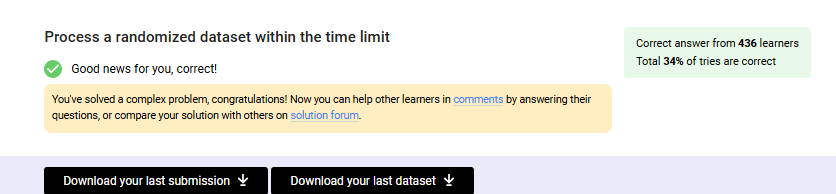

# 1.4 Epilogue: How Does Tuberculosis Hibernate?



1.  **The Biological Problem:** Tuberculosis (TB) is a deadly disease primarily because the bacterium can enter a dormant, latent state inside the human body. This "hibernation" makes it resistant to antibiotics and allows it to persist for decades.

2.  **The Trigger for Dormancy:** This latent state is strongly associated with low-oxygen (hypoxic) conditions. The bacterium senses this oxygen shortage and activates a survival program.

3.  **The Genetic "Master Switch":** A transcription factor protein named **DosR** (Dormancy Survival Regulator) acts as the master switch that controls the genes responsible for this adaptation to hypoxia.

4.  **The Unsolved Puzzle:** While DosR was identified as the key regulator, the specific DNA sequence (the binding site or "motif") that it recognizes to control other genes was unknown.

5.  **The Computational Goal:** The objective is to find this hidden DosR binding site by analyzing the DNA sequences (upstream regions) of genes known to be affected by DosR during hypoxia.

6.  **The Strategy - Testing Different Lengths:** Researchers used various motif-finding algorithms (`MedianString`, `RandomizedMotifSearch`, `GibbsSampler`) to search for patterns of different lengths (`k`-mers from 8 to 12) to see which length revealed the most stable and consistent signal.

7.  **A Key Breakthrough - Signal Stability:** The `MedianString` algorithm provided the strongest evidence for the motif's length. It found a highly stable consensus string, **`GGACTTCCGGC`**, at a length of 11. When `k` was increased to 12, this core pattern remained, indicating 11 is likely the correct length.

8.  **Finding a Longer Context:** Faster algorithms like `RandomizedMotifSearch` and `GibbsSampler` identified a longer, 20-nucleotide consensus motif (`CGGGACCTACGTCCCTAGCC`).

9.  **Synthesizing the Results:** Crucially, the stable 11-mer motif was found to be embedded within this longer 20-mer. This suggests the 11-mer is the core functional part of a potentially larger recognition site.

10. **The Final Challenge:** Although the algorithms successfully inferred the likely binding site, they produced slightly different results. The ultimate scientific challenge is to synthesize this information into a single, definitive profile of the DosR motif to identify all the genes it regulates in the entire TB genome.

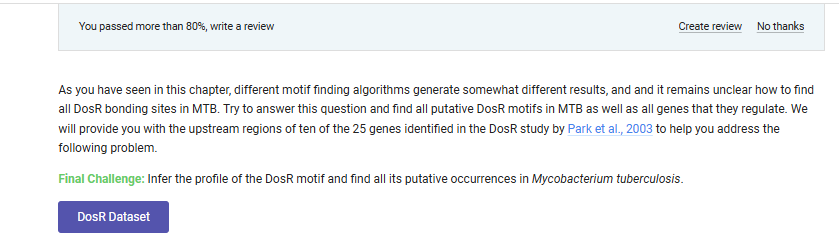

In [13]:
#@title Dataset given in the challenge
k=15
t=20
N=2000
Text = "TGAGTCCAAGAGTGAACTACGGAGCGAAACCGAATTCGACGGGCGTTCGTAGCGGGGCAATCAACTCCGGGCACGAAACGGTACGCGAGACAATGTAGGACCATCGGTTGACACAATTAAGCATAAACTCGAATCGCCGCAATTATCGTGATTACAGTGTGACTGCCTAGCCAGCGTATGCGGAATATGGGAGACGTTTAATCGAAGAAGCTCGAACTGACGACCTACGCTCTTCAATGAGAGGATAATTGAACTACAAATGCTAATCGGATTGTCCTCTCACTAGTTCCGATTACGTGACCAAACTTGAGTCCAAGAGTGA ACTACGGAGCGAAACCGAATTCGACGGGCGTTCGTAGCGGGGCAATCAACTCCGGGCACGAAACGGTACGCGAGACAATGTAGGACCATCGGTTGACACAATTAAGCATAAACTCGAATCGCCGCAATTATCGTGATTACAGTGTGACTGCCTAGCCAGCGTATGCGGAATATGGGAGACGTTTAATCGAAGAAGCTCGAACTGACGACCTACGCTCTTCAATGAGAGGATAATTGAACTACAAATGCTAATCGGATTGTCCTCTCACTAGTTCCGGGTGGCACGTTATCGATTACGTGACCAAACTTGAGTCCAAGAGTGA CACGAGACCATATGGGGAAACCCACCAGCCAAGCTCGTGCTATATCACCTGGGCCGGAGATATGTTCTGGCCGAGTTTTACACGTACGCACACTGAATTCAAAGAAGTCTACGGCCAGGTTTCCACGACACACAGTTACCGTAATACTTCCTATGGTGACCTATCCGATGCGAGAATAGAGCTTTACCGGCGCCTAGCAGGTGTCGGGGCAGGATCTTGTGGCGATTAGTGAGTATGGCTAGAGGATCGTTGCTATAAGAAGGCATAACGCGGTAAGCAGTCTATTTTCTGACACAGTGGTACCGGTACTTTTCCCCGCGTC GGTCGCAACACCTTAGCCTCCCGTCCCTTCTTCAGGAACCCACGCCCGGCTGCCTGCCCTTTCGCCGGTAAGCACTACATAGTCCAGAGTGACTCTAACAGAGTTGTAAATCCTATCTTTCTTCGCTCAGCTAGCTGTACTGTCAACTGGAGTTTAGATACCTGCAAGGTCTTTTAAAGGAAGTATTTGGAAACTCATTGACGAGCTTTTAGACCCCAAATCAGCTTCACCTTCCCATCGCAAGGACAGCCAGAGCTTAGGGTGACGCAACGAATGTGGACTGTCAAGAATCCGGCCTTGCCCCTCACTGTCATGCCGGAGT GCTTCTCACGTGAGCGAGACGAGCACTCGACCGGGTCTCCACGTTCGCTTCAAGTTGCCTCACGACGTCAACATTTACGAGCTGTATCCTATATACGCAATAACTGGGTTAGCTAACGCCAACTGACTGAAAATCGAGTTCCTGACGACGCCATACTCTCTTGATGAAGGCTCGACGGGTGAAAAAGTTTAGTGTAGGCCTGTGCAGGGAACAGGAGATGTTGTCAGATGGTGCTCAGCCCGGTAAGCACGGCCTAACTAACACATTAGCGCGCTATATACTGGTCAGACAATTCCCTTACAGTCGTAGACACGCCAGCGCG AGGCTCGACGTCACATGCCGCATGACGAACCCAGCGAAGGCGTATAAACCTACAGTTCAGATCGTTTACCATGAAGCACGTTATACACTCGTACTTTTTCTCATATCATGAGGGATAATAGAGGACAGAAAATTTTCATCATACACAAACCGATCACCTTGAATTCATTCGATGTGTTCGGCGCCCTATACAACACGATTTTCCCTGATTAATAAGGACTCCTGTAAGCTGATCCTCGCACCACTTTCATCTGAAATGGGCCAAGCCGGACAAACCACACCACCAGTCCAATCAATTTCGTCTGCGGCCACTGGTAATTAGG TCCGCTTTTCATGAGGAGGGTTCACACATGCCCCCTAAGAGGTGCAAACCCGCTTGTAGTGCTAAATGGACTTATATCTTTTTCAATACTTCCCGATTTTAGAGAGATATAAAAGAACCTGTGAGCCGGTAAAAGCGTTATGCCGCGGGAACCTGTGTATCCGGAACTGGGCACTAGAGTTTATCGTGGTCGATGCGCGCATCCAACGGAATCAGAAAGGCCAGAACTAAAGGCCGAATGCCGGGGTAAATTGCGTCGCCAGGCCCGCACAACCCCCCTGCATCATATAACTAACTAGGCTCTGCGAGATGATAGGACTCAA GCATTACGTCGCTCACATCCAACGCCCGTTTTGTGCAGATAACAACTACATCCGACAAGTTCATTGGATATGACGCGTGGTCCTATATCAAAACAAACAGTCAGAGGATGGTAGATCTACCCGTTCCAGACATAACGTTAGTGGGAAGTAAATCAGACGCCGTGTATCGAACCCAACATCCAACGAAAATGGACGAAACACAGTTCCACAGTGTACAAATCGGTAACTGCGTTATTGCACACATGAGTCTTCGAATAGAAGGATGTTGCAGGCAACCTGAGGATGCCGTTTCATGGTAAGCCTCCTGTCTATACTTGACTAA CGTTCACGCCGTCCGCCAGTAACTGATTGTGAGTCCCTACCGTACCCGTTTATGATGTTGGCATTATTGTGGAACGCCGCATTTTGTTGGTATTATTAACACGGGATCGGTAAGCACGTATCGCGTTGGCAAAAGCGCTGCACAGTAGCCGTGCAGAAGTACTTATCTTCGCGGCTTTCATTGATTCGCAGGCTCGAAAACATCTGCTCATCGCGCACTTCTGACTGACCGGAGTGTTCGGCCTCTTCGCGAACAGTCCGTCGTTTCTACTTCTTAGAATGCCTCGTGGCCATCACTGCCCGTGAAGACACTGGGCTCAACT TCGGTATGCGGCCCAACGCTTATTAGTAATGGGCCAAACAGGTGGACTGCCTCAGTCGTTATACTTGTTGCGATTACCTCTGTGAGCTGTCAGAACAGCGAAGACCGGATATTCTTCTGGTAAGCCGCTGCGAGTTTTTCGGGATGAGGTAAGCACGTTCGAATTTGTCTGCACCTTCAATTAGGACCTGGACGATCAGATATGATTACGTAGCTACGTGTCTTACCCTCATGGATCACCGAGCGGCCGATAGGGTGCGCCTAGACTGGCGGGTACGTAGGACCGTAAACGCAAATCTAGGTTACAGGCATATCGCTCGTGG GCTGGGCGCAGCGACCGCTGGTACATGAGTTGGATGGTAGTTCGTTTATAGACGGCTAGTGAGTACGGGGATGTGGGCGTATTCAGTTGAGATTTGTTATTCCGGACTGTTCATATTCCGATGGCTGAGTCATACTGTGGGACATAATAGAATGTGGACTAGTAAGCACGTTACCTAGCAATGAATATGTAAGCTCGAGAGCTTCTCTGGTACATCGCACAGAAGTCGAGTGAAACCACTATCCTGCGGTATAGCAGATACTTATCTTTGAGCCGATCGGCAATGTGATACGGGTCCTGAGAATGGATCGCGGCTGGCTCAG ATGATAATAACACGATAGTCACGGACCTACTAGTCAACCTATGAACTATACTCCTTATCAATGACTCCCTGCCTCTATTATACACAGAAGGTCCTAATTACGGTATATACGTTATTTTATCTCGATTTGCCCAGGAGCTGCAGCGGCCCAACCTACGCCCAAGAGTTGCGTCCTGGGCCTTGGCCGTGATACACGGAAGGATCTGCCTGTCACGGAGTGTCGGACGGATCACAAGCCTAGAGAGTGCCGGTTAGGCCCTTAAGGACGAACGAGTACATGGATCACAACTCAACGTCGTTGTGACCTTCCAGAATGATTAGTA AGTATATACGGCCGGAGCAGGTAGTAATGGCACTAAGGTTGTTCACTAAAAGTCTAACTCGTAATTTATTGAGACTCTAATCCATTATCAAAATAGATAAAAGGGAGAAATACGCTCTGCCCTGTACAGATGCCCCGGATCTCCGGGGACGTGCGTCTTTGCCGTGGAGCGTCGGTCCAGAGCACAGGCCCTTATGAGATGGCCAAGGTATACGCATATTATTCTTGGACATGCTGATTTCCCAACGAGTTACCTCGAGATGGCAAAATAGTCTCGCCACCCATATCGCCTAGCACGTTATGAACACATAGCAGTCAAGCTT GTCCAAGTCACTACCCGGTGCACACGTTATAGGACGCGCTTACGGTAGGGTTTCTGCTGTTATCGTCGTGCTTAGTCTTTTGAATGATAATTACCACACCTCCCTCCGAGAGCAACCCTGTGGGGCGTCGTGACGACACTGTAAACAGATATAGATTGTCGACCAATATTCACGGAAGTGTGCAGGGAACTTTGCAGTCAGTTTCAAAGGACTAATTCGCGCATTACTGCAACACTACTATTCTCCACTAAGCAAGCCACGTCATAAGCATCATCAATCCAATATTGATCGCAACTTGTCAAGAGCTATTTTCACTGAGGTC AGATGCTGAAAAACCCCTGATGGACTTCGGTGCCGTCCCTTCTTAGTCGTCTATGCGTAGGCGCCTCGTCCCATGGTATCCTACAAATTTAGACGCGGAGGGTCGCATCCGTGGGAAGTTGCATGGTCTGCGGGGCAGCGAGTGTCCGAGAGTCTCCGCTGCTCTTAAACATTACATTCCGAGGGACATACTCTATGCAGATTCTGCAACCTGAATACGACTAGGAAGTGCCCAACATGCTTGGGTAGCGGTACTGACGTTATATGGACCACGCCGTACACGCTTCATGCGTGTACCCAATGTCTGGATGTTCATTCAACCT ATACTGATCCCCACATAATACGCGTGGTGGGGATCTACGACACGCCATTGATCCCTACGTGGCTCGAAGCCTTTCCTAGGAGGCTGTAGTAGGTTCTTGGAAGGAACCATAGCGTTGTTGCATTAAGAGATAATGGTGGCGGCTGCCGAAGTCTCATCAGTCTAATAGCTGTTTAATTTACCACAATGGATGCTGGTTCACCTAAGCACGTTATGAATCTTTGTCGCCTTTTAAGACTTGGCAAACTGAGATAACACCGGTCATACCTAAATCACTGTTCCCTGATGCCGGCCGCTTCCAACGTCCGGAGAAAATAGGGGCG GAGTTGACTTTTTAATGTGACCGGTAAGCCATTTATCCATGTTATCCCGATTATAACATGCAACGTAGGGTGCAGAGATGGGTACGCATACTTCTTGTGTATCTAGCGAGTAGGCTTCTGGGTGTAAGGGGAATCCCCGATTTGCATCTCTCCTGAACCGAAGCGATGCTTGTCTTAGTTTGAAGCTCCGTCACTAAGATGCTACGCACCCTCCGCAAGTCTCACTCCGTGCCGATAAGTGATAAATCCTTGGACTCGCTGCTTGAGAAGCAGAGGTTTCGTTTCGCGGCGTAGGAAGGTGCGCAGCTACGATGCAGCGCGG GTGTAATTTGATAGAATAAGAAATTAGTGCAAGTACACAAAATGATCATGAGCGAAGATCGTAGGCACCGGTCCTCGAGGGAGCCCAGCCAGGATAATTATTTAAAGAGCGGGTAAATCCGAAGCTCAAGTAGGATTGGGCATCCGAGGGACAATAAATCTTATGGAAGCTTGTAGGTCGGTTTTCTTACAGCAATAGCTTATGTCAACTATGGTTTCGGCGATGCGGACGACGCCCACCTCCTAAAGAGCGGGCGGCACGTTATTCGCAATCACATATCGGCGGAGGCGACCGCAACTAAGTAAGCTTATTTCTTCTCGGT ACGATATCCGTTCTGTCCTATTGGCTGTCAAAGCGCATAGATACCGATACGCGCACCCTGGACATACTGAGGTCAGTGTAGCCGGACGCCACTAAACTGAGTATAATTGTATGTAATCGTCAGTATCTTTAGCCTGACTTCATGGCTTAACAGGTAGCTCACGATTACTGCATTAAAGCCGGTTGCGCGGGGGTCTTACGGTCTACACGTTATTTGCGGTGCCACGACCAGCGGATCTACTTCCAGCGCACCCGCTTATGCAAAGGCGTACAACACTTCTATTCCTTTGCATGTACAGAGCAATACCTACCAGAGAGAAGAT CACATATGAGCCAGGTTAGTTTATGGGCGGTAAGACAGTTATCGATATATGAGAAGAAAACAAACCAACATGGAGGGCTGGTTGCGTGGGGCCGGGTACCCAGTGAAACCGAAGGCTATCCCTTCAGGCCGGCGCCGAATTACAAGCTACGCCCACGTAAACCGGGTATGAATTTACACGCTTGATTCTGGGGAGGACCTTTACTGGAAGCCACCAAACAATCTGGCAGGCAAGTAATATCTTTGTGGATTGGTGCGTCGGATGCTACGACACACGAGGGGTACCTTACATAACTAATGTACGCAACGCGCCATTTGCCAAT"
Dna = Text.split()

In [14]:
import random
import sys

# --- Helper Functions (Score, Profile, Probability, etc.) ---

def score(motifs):
    """Calculates the consensus score of a collection of motifs."""
    k = len(motifs[0])
    t = len(motifs)
    score = 0
    for i in range(k):
        counts = {'A': 0, 'C': 0, 'G': 0, 'T': 0}
        for j in range(t):
            nucleotide = motifs[j][i]
            counts[nucleotide] += 1
        max_count = max(counts.values())
        score += (t - max_count)
    return score

def create_profile_with_pseudocounts(motifs):
    """Creates a profile matrix from a list of motifs with pseudocounts (Laplace's Rule)."""
    k = len(motifs[0])
    t = len(motifs)
    # Start with pseudocount of 1 for each nucleotide
    profile = {'A': [1] * k, 'C': [1] * k, 'G': [1] * k, 'T': [1] * k}
    for i in range(k):
        for j in range(t):
            nucleotide = motifs[j][i]
            profile[nucleotide][i] += 1
    # Normalize to probabilities
    for nucleotide in profile:
        for i in range(k):
            # Total count is t motifs + 4 pseudocounts (1 for each base)
            profile[nucleotide][i] /= (t + 4)
    return profile

def kmer_probability(kmer, profile):
    """Calculates the probability of a k-mer given a profile."""
    prob = 1.0
    for i, nucleotide in enumerate(kmer):
        prob *= profile[nucleotide][i]
    return prob

# --- Core Gibbs Sampler Algorithm and its Helpers ---

def biased_random_generator(probabilities):
    """Simulates a biased die roll based on a list of weights."""
    total_sum = sum(probabilities)
    if total_sum == 0:
        return random.randint(0, len(probabilities) - 1)
    random_pick = random.uniform(0, total_sum)
    current_sum = 0
    for i, prob in enumerate(probabilities):
        current_sum += prob
        if random_pick < current_sum:
            return i
    return len(probabilities) - 1

def profile_randomly_generated_kmer(text, k, profile):
    """Selects a k-mer from text based on profile probabilities."""
    n = len(text)
    probabilities = []
    for i in range(n - k + 1):
        kmer = text[i:i+k]
        probabilities.append(kmer_probability(kmer, profile))
    chosen_index = biased_random_generator(probabilities)
    return text[chosen_index : chosen_index + k]

def GibbsSampler(Dna, k, t, N):
    """Performs one complete run of the Gibbs Sampler algorithm."""
    motifs = []
    for text in Dna:
        start = random.randint(0, len(text) - k)
        motifs.append(text[start : start + k])

    best_motifs = list(motifs)
    best_score = score(best_motifs)

    for _ in range(N):
        i = random.randint(0, t - 1)
        motifs_subset = motifs[:i] + motifs[i+1:]
        profile = create_profile_with_pseudocounts(motifs_subset)
        motifs[i] = profile_randomly_generated_kmer(Dna[i], k, profile)

        current_score = score(motifs)
        if current_score < best_score:
            best_score = current_score
            best_motifs = list(motifs)

    return best_motifs, best_score

# --- Main Workflow for the Final Challenge ---

if __name__ == '__main__':

    num_starts = 50 # Number of random starts to increase chances of finding the global optimum

    # Step 1: Discover the best possible motifs by running GibbsSampler multiple times
    print(f"--- Step 1: Running GibbsSampler with {num_starts} random starts ---")
    best_overall_motifs = []
    best_overall_score = float('inf')

    for i in range(num_starts):
        motifs, current_score = GibbsSampler(Dna, k, t, N)
        if current_score < best_overall_score:
            best_overall_score = current_score
            best_overall_motifs = motifs
        sys.stdout.write(f"\rRun {i+1}/{num_starts}, Best Score so far: {best_overall_score}")
        sys.stdout.flush()

    print("\n\n--- Best motifs discovered ---")
    for motif in best_overall_motifs:
        print(motif)
    print(f"Best Score: {best_overall_score}")

    # Step 2: Infer the profile of the DosR motif
    print("\n--- Step 2: Inferred Profile of the DosR Motif ---")
    dosr_profile = create_profile_with_pseudocounts(best_overall_motifs)
    print("      " + " ".join([f"Pos{i+1:<3}" for i in range(k)]))
    for nucleotide, probs in dosr_profile.items():
        print(f"  {nucleotide}:  " + " ".join([f"{p:.3f}" for p in probs]))

    # Step 3: Determine a score threshold based on the discovered motifs
    print("\n--- Step 3: Determining Probability Threshold ---")
    motif_probabilities = [kmer_probability(m, dosr_profile) for m in best_overall_motifs]
    threshold = min(motif_probabilities)
    print(f"Threshold set to the probability of the least likely motif in the best set: {threshold:.2e}")

    # Step 4: Find all putative occurrences in the original DNA
    print("\n--- Step 4: Scanning for all Putative DosR Occurrences ---")
    putative_occurrences = []
    for i, text in enumerate(Dna):
        for j in range(len(text) - k + 1):
            kmer = text[j:j+k]
            prob = kmer_probability(kmer, dosr_profile)
            if prob >= threshold:
                putative_occurrences.append((kmer, i, j, prob))

    # Sort by probability for better presentation
    putative_occurrences.sort(key=lambda x: x[3], reverse=True)

    print(f"Found {len(putative_occurrences)} putative motifs meeting the threshold.")
    print("-" * 60)
    print(f"{'Motif':<15} {'String #':<10} {'Position':<10} {'Probability':<15}")
    print("-" * 60)
    for motif, str_idx, pos, prob in putative_occurrences:
        print(f"{motif:<15} {str_idx:<10} {pos:<10} {prob:.2e}")

--- Step 1: Running GibbsSampler with 50 random starts ---
Run 50/50, Best Score so far: 63

--- Best motifs discovered ---
CGGTACGCGAGACAA
CGGGTGGCACGTTAT
CGGTAAGCAGTCTAT
CGGTAAGCACTACAT
CGGTAAGCACGGCCT
CATGAAGCACGTTAT
CGGTAAAAGCGTTAT
CGGTAACTGCGTTAT
CGGTAAGCACGTATC
AGGTAAGCACGTTCG
TAGTAAGCACGTTAC
CGGTATATACGTTAT
CGCCTAGCACGTTAT
CGGTGCACACGTTAT
CGGTACTGACGTTAT
ACCTAAGCACGTTAT
CGGTAAGCCATTTAT
CGGGCGGCACGTTAT
CGGTCTACACGTTAT
CGGTAAGACAGTTAT
Best Score: 63

--- Step 2: Inferred Profile of the DosR Motif ---
      Pos1   Pos2   Pos3   Pos4   Pos5   Pos6   Pos7   Pos8   Pos9   Pos10  Pos11  Pos12  Pos13  Pos14  Pos15 
  A:  0.125 0.125 0.042 0.042 0.667 0.583 0.208 0.125 0.667 0.167 0.042 0.125 0.083 0.750 0.083
  C:  0.750 0.083 0.125 0.083 0.125 0.167 0.083 0.667 0.125 0.708 0.042 0.083 0.167 0.125 0.125
  G:  0.042 0.750 0.750 0.167 0.083 0.125 0.625 0.083 0.167 0.083 0.750 0.083 0.042 0.042 0.083
  T:  0.083 0.042 0.083 0.708 0.125 0.125 0.083 0.125 0.042 0.042 0.167 0.708 0.708 0.083 